用pytorch实现BPNN（backpropagation artificial neural network）

In [1]:
import torch
import torch.nn as nn
from sklearn import preprocessing
from matminer.featurizers.composition import alloy
from matminer.featurizers.conversions import StrToComposition

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
data = pd.read_csv('data.csv')

# Convert formula to composition
data = StrToComposition().featurize_dataframe(data, 'formula')
# 然后基于composition计算特征
data = alloy.WenAlloys().featurize_dataframe(data, 'composition')

StrToComposition:   0%|          | 0/999 [00:00<?, ?it/s]

WenAlloys:   0%|          | 0/999 [00:00<?, ?it/s]

In [29]:
data.dropna(axis=1, how='any', inplace=True)

# 选择前1500条数据作为训练集和验证集；后500条数据作为验证集。
data_fit = data.iloc[:600]
data_test = data.iloc[600:800]

# data_fit_X = data_fit[['APE mean', 'Electronegativity local mismatch', 'VEC mean', 'Shear modulus mean', 'Shear modulus delta', 'Shear modulus strength model']]
# data_fit_y = data_fit[['SFE']]
# data_test_X = data_test[['APE mean', 'Electronegativity local mismatch', 'VEC mean', 'Shear modulus mean', 'Shear modulus delta', 'Shear modulus strength model']]
# data_test_y = data_test[['SFE']]

fea_num = 5
X = ['Nb', 'Mo', 'Ta', 'W', 'Yang delta', 'Yang omega','APE mean', 'Radii local mismatch', 'Radii gamma', 'Configuration entropy', 
                       'Atomic weight mean', 'Total weight', 'Lambda entropy', 'Electronegativity delta', 'Electronegativity local mismatch', 'VEC mean', 
                       'Mixing enthalpy', 'Mean cohesive energy', 'Shear modulus mean', 'Shear modulus delta', 'Shear modulus local mismatch', 'Shear modulus strength model']
Y = ['SFE']
# X = X[:fea_num]
X = ['VEC mean', 'APE mean', 'Electronegativity local mismatch', 'Shear modulus delta', 'Mo']

data_fit_X = data_fit[X]
data_fit_y = data_fit[Y]
data_test_X = data_test[X]
data_test_y = data_test[Y]


In [30]:
# # 数据归一化
# min_max_scaler = preprocessing.MinMaxScaler()
# data_fit_X = min_max_scaler.fit_transform(data_fit_X)
# data_test_X = min_max_scaler.transform(data_test_X)

# 数据标准化
standard_scaler = preprocessing.StandardScaler()
data_fit_X = standard_scaler.fit_transform(data_fit_X)
data_fit_y = standard_scaler.fit_transform(data_fit_y)
data_test_X = standard_scaler.fit_transform(data_test_X)
data_test_y = standard_scaler.fit_transform(data_test_y)


# 将数据类型转换为tensor
data_fit_X = torch.FloatTensor(data_fit_X)
data_fit_y = torch.FloatTensor(data_fit_y)
data_test_X = torch.FloatTensor(data_test_X)
data_test_y = torch.FloatTensor(data_test_y)

In [38]:
# # 定义神经网络
# class BPNN(nn.Module):
#     def __init__(self, n_feature, n_hidden, n_output):
#         super(BPNN, self).__init__()
#         self.hidden = nn.Linear(n_feature, n_hidden)        # 定义隐藏层
#         self.out = nn.Linear(n_hidden, n_output)        # 定义输出层
#     def forward(self, x):
#         x = nn.functional.relu(self.hidden(x))        # 定义隐藏层激活函数
#         # out = nn.functional.softmax(self.out(x), dim=1)        # 定义输出层激活函数
#         out = nn.functional.relu(self.out(x))
#         return out

class BPNN(nn.Module):
    def __init__(self, n_feature, n_hidden1, n_hidden2, n_output, n_layers):
        super(BPNN, self).__init__()
        self.n_feature = n_feature
        self.n_hidden1 = n_hidden1
        self.n_hidden2 = n_hidden2
        self.n_output = n_output
        self.n_layers = n_layers
        self.input_layer = nn.Linear(self.n_feature, self.n_hidden1)
        self.hidden1 = nn.Linear(self.n_hidden1, self.n_hidden2)
        self.hidden2 = nn.Linear(self.n_hidden2, self.n_hidden2)
        self.predict = nn.Linear(n_hidden2, n_output)

    def forward(self, x):
        out = self.input_layer(x)
        out = nn.functional.relu(out)
        out = self.hidden1(out)
        out = nn.functional.relu(out)
        if self.n_layers == 2:
            out = self.hidden2(out)
            out = nn.functional.relu(out)
        out = self.predict(out)
        return out


In [51]:

# 设置超参数
lr=0.001 #学习率
epochs=1000 #训练轮数
n_feature=5 #输入特征
# n_feature=len(X) #输入特征
n_hidden=20 #隐层节点数
n_output=1 #输出（层错能）

In [52]:
# 定义优化器和损失函数
# net = BPNN(n_feature=n_feature, n_hidden=n_hidden, n_output=n_output)
net = BPNN(n_feature=5, n_hidden1=20, n_hidden2=20, n_output=1, n_layers=2)
optimizer = torch.optim.Adam(net.parameters(), lr=lr)                           # 使用Adam优化器，学习率为0.02
loss_fun = nn.MSELoss()                                                    # 定义损失函数为均方差

from torchmetrics import R2Score
r2 = R2Score()

In [53]:
# 训练数据
train_loss = np.zeros(epochs)                               # 记录每一轮的损失函数值
test_loss = np.zeros(epochs)                           # 记录每一轮的准确率

for epoch in range(epochs):
    y_pred = net.forward(data_fit_X)                                   # 前向传播
    loss = loss_fun(y_pred, data_fit_y)                        # 计算损失函数
    optimizer.zero_grad()                                      # 清空梯度
    loss.backward()                                            # 反向传播
    optimizer.step()                                           # 更新梯度
    train_loss[epoch] = loss.item()                             # 记录损失函数值
    print('Epoch: ', epoch, '| train loss: %.4f' % loss.item())
    # with torch.no_grad():
        # print(net(data_test_X[0]))
        # y_pred = net(data_test_X)
        # correct = (torch.argmax(y_pred, dim=1) == data_test_y).type(torch.FloatTensor)
        # accurate_steps[epoch] = correct.mean()              # 记录准确率
        # print('Epoch: ', epoch, '| test accuracy: %.4f' % accurate_steps[epoch])
    net.eval()          # 进入评估模式
    y_test_pred = net.forward(data_test_X).detach().numpy()
    y_test_true = data_test_y.detach().numpy()
    mse_loss = loss_fun(torch.FloatTensor(y_test_pred), torch.FloatTensor(y_test_true))
    test_loss[epoch] = mse_loss.item()
    print('Epoch: ', epoch, '| test loss: %.4f' % mse_loss.item())
    print(r2(torch.FloatTensor(y_test_pred), torch.FloatTensor(y_test_true)))

Epoch:  0 | train loss: 0.9937
Epoch:  0 | test loss: 0.9873
tensor(0.0127)
Epoch:  1 | train loss: 0.9907
Epoch:  1 | test loss: 0.9840
tensor(0.0160)
Epoch:  2 | train loss: 0.9876
Epoch:  2 | test loss: 0.9807
tensor(0.0193)
Epoch:  3 | train loss: 0.9847
Epoch:  3 | test loss: 0.9774
tensor(0.0226)
Epoch:  4 | train loss: 0.9818
Epoch:  4 | test loss: 0.9742
tensor(0.0258)
Epoch:  5 | train loss: 0.9789
Epoch:  5 | test loss: 0.9710
tensor(0.0290)
Epoch:  6 | train loss: 0.9761
Epoch:  6 | test loss: 0.9677
tensor(0.0323)
Epoch:  7 | train loss: 0.9734
Epoch:  7 | test loss: 0.9644
tensor(0.0356)
Epoch:  8 | train loss: 0.9706
Epoch:  8 | test loss: 0.9612
tensor(0.0388)
Epoch:  9 | train loss: 0.9678
Epoch:  9 | test loss: 0.9579
tensor(0.0421)
Epoch:  10 | train loss: 0.9650
Epoch:  10 | test loss: 0.9545
tensor(0.0455)
Epoch:  11 | train loss: 0.9621
Epoch:  11 | test loss: 0.9511
tensor(0.0489)
Epoch:  12 | train loss: 0.9592
Epoch:  12 | test loss: 0.9476
tensor(0.0524)
Epoch:

In [54]:
train_loss

array([0.99371845, 0.99067414, 0.98764646, 0.98468107, 0.98177409,
       0.97892088, 0.97612536, 0.97335356, 0.97059232, 0.96780783,
       0.96498364, 0.96212679, 0.95923728, 0.95630819, 0.95334929,
       0.95034772, 0.94729978, 0.94418865, 0.94101453, 0.93775135,
       0.93439078, 0.93093425, 0.92739052, 0.92373109, 0.91994923,
       0.91605735, 0.91205221, 0.90791827, 0.90365744, 0.89924604,
       0.89469922, 0.89002085, 0.88519096, 0.88019651, 0.87504739,
       0.86975807, 0.86432189, 0.85873097, 0.85303819, 0.84723443,
       0.84129214, 0.83523679, 0.82909131, 0.82285535, 0.81650329,
       0.81004703, 0.80349499, 0.7968871 , 0.79022205, 0.78348452,
       0.77668262, 0.76979154, 0.76284146, 0.75585073, 0.74881071,
       0.74170715, 0.73448795, 0.72718602, 0.71977842, 0.71231639,
       0.70481664, 0.69726241, 0.68963408, 0.68191487, 0.67411029,
       0.66618514, 0.65808171, 0.64983839, 0.64159036, 0.63330686,
       0.62494957, 0.61651838, 0.60803276, 0.59952515, 0.59101

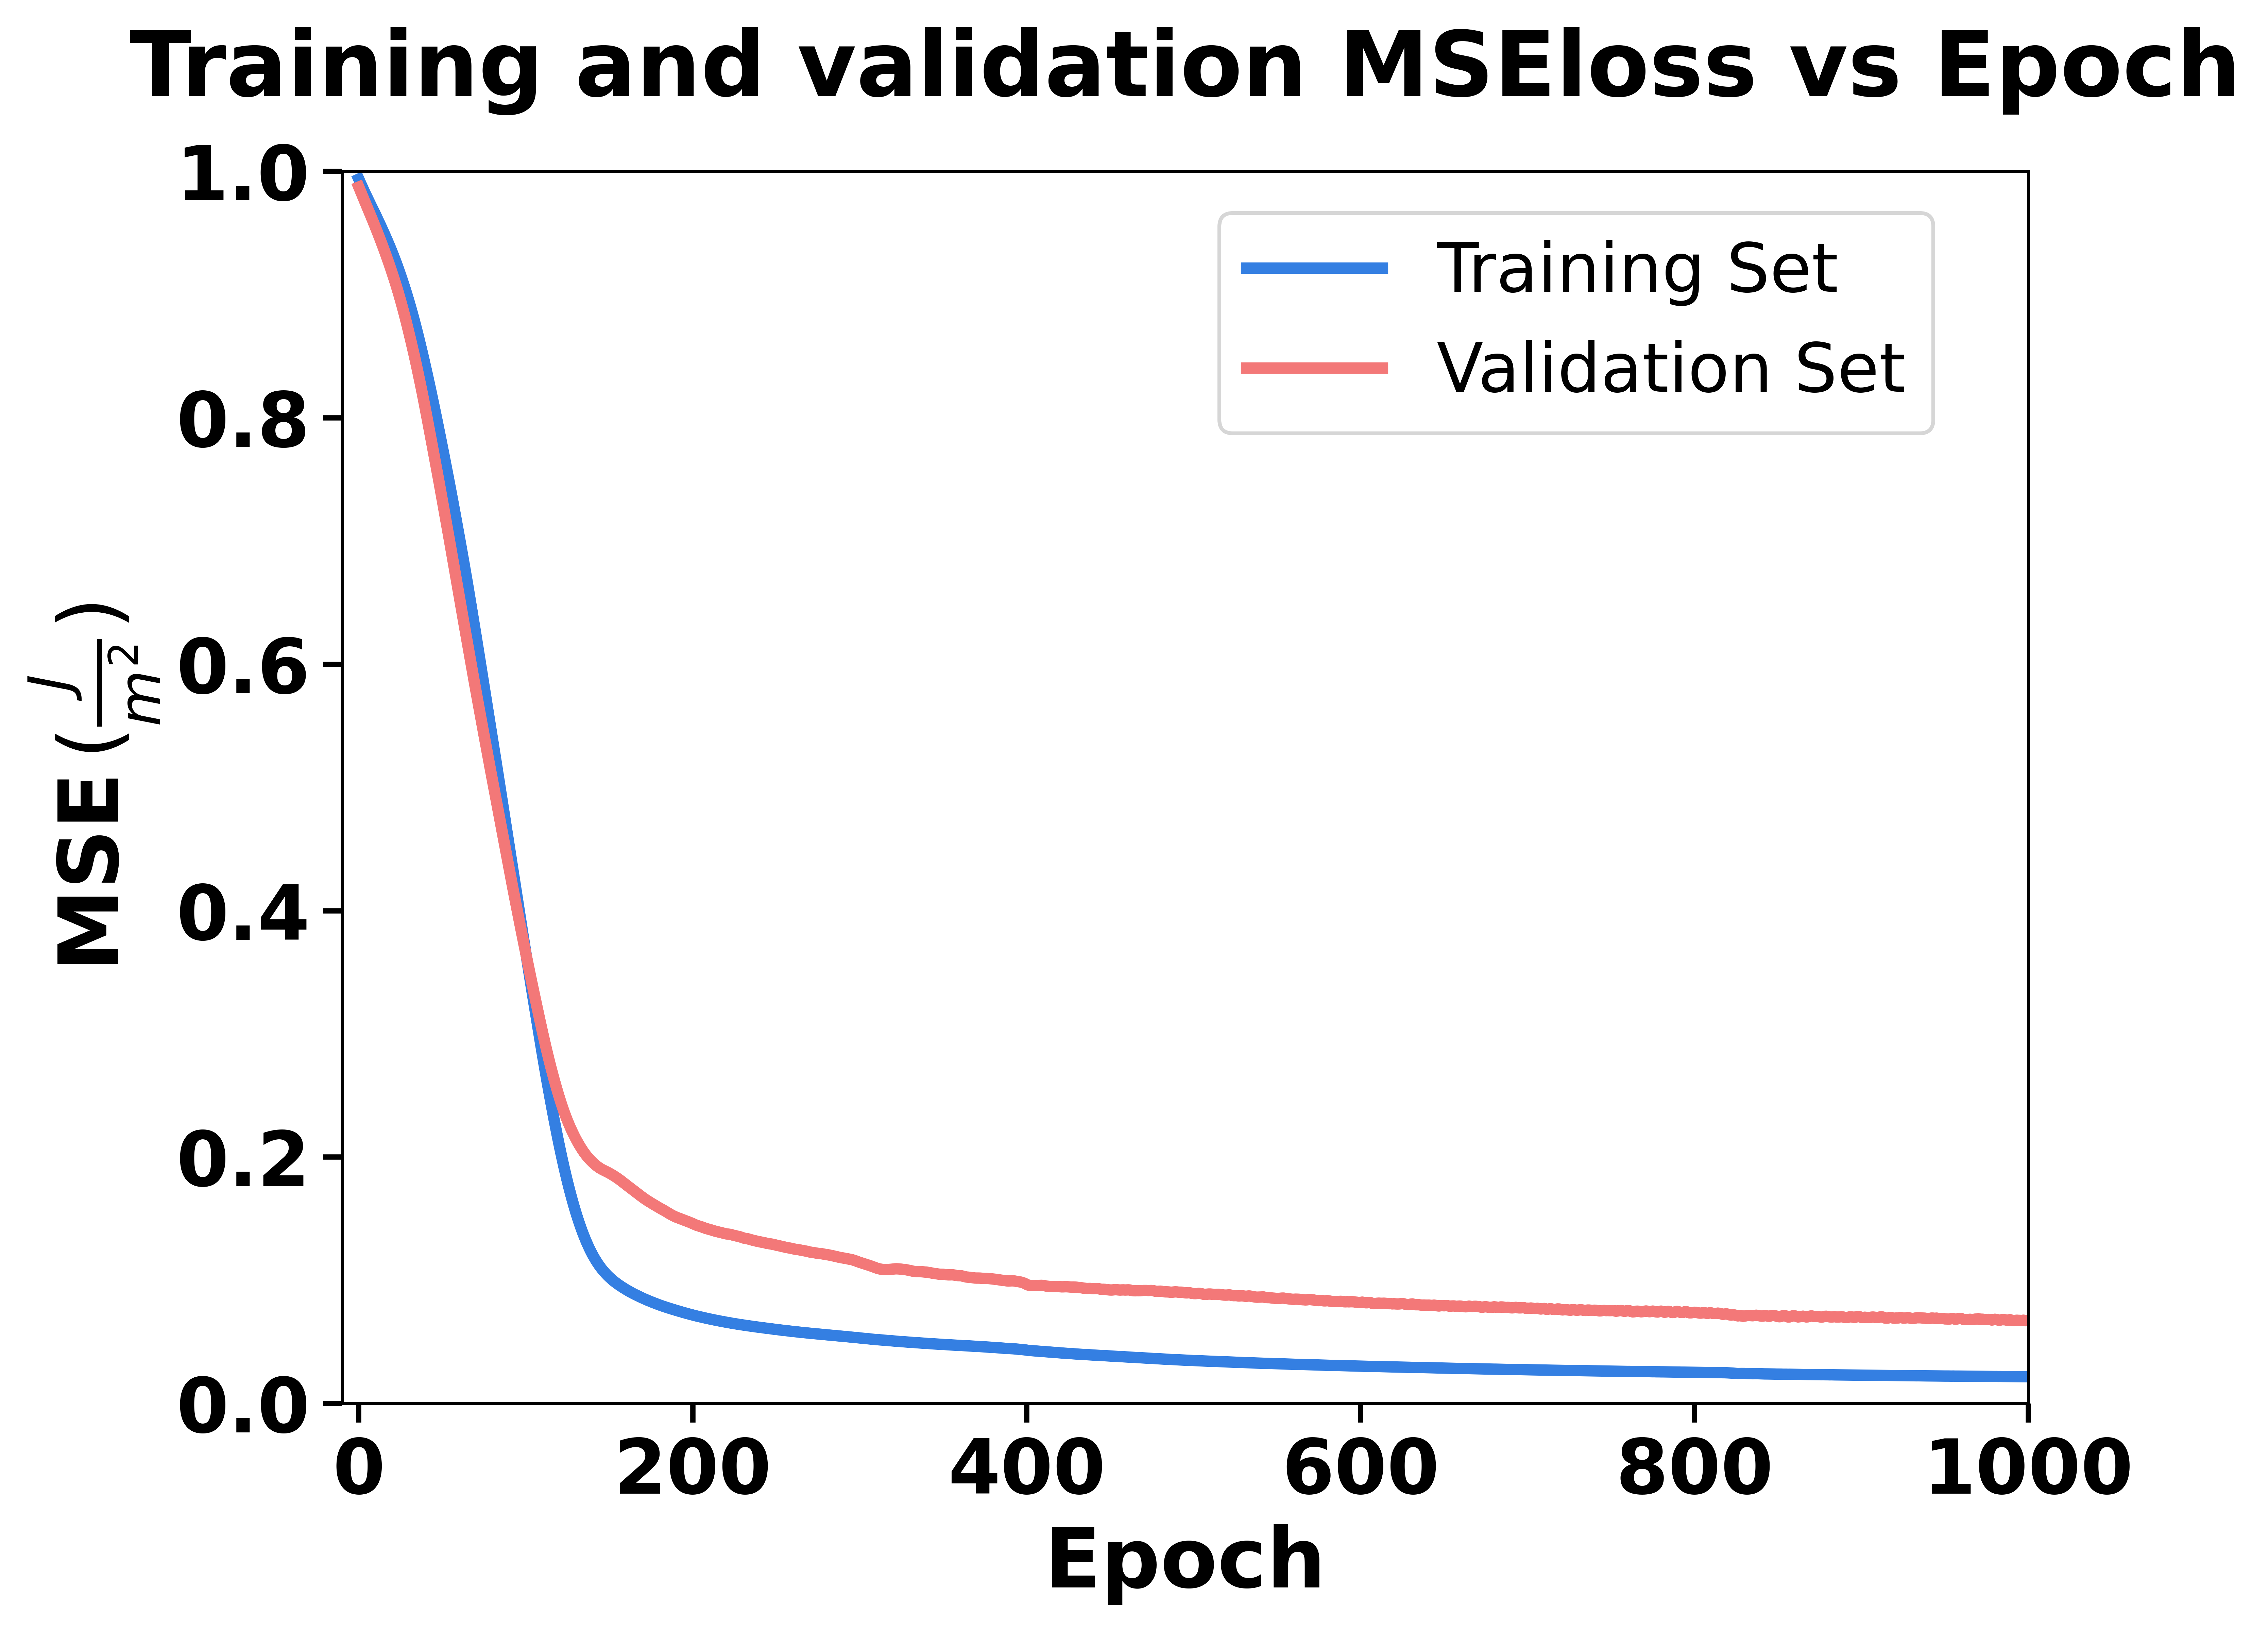

In [59]:
title_font = {"fontsize": 24,}
label_font = {"fontsize": 22,}
text_font = {"fontsize": 18,}
pad = 20
xpos, ypos = 365, 0.015
ticks_size = 20
linewidth = 3.0
legend_size = 18
figsize = (8, 6)
dpi = 800

ytrain = train_loss
ytest = test_loss
tx = np.arange(0, epochs, 1)

fig = plt.figure(figsize=figsize, dpi=dpi)
ylabel = 'MSE' + r'$\/(\frac{J}{m^2})$'
xlabel = 'Epoch'
title = 'Training and validation MSEloss vs Epoch'
xlim = (-10, 1000)
ylim = (0, 1)
xticks = (True, (0, 200, 400, 600, 800, 1000))
yticks = (True, tuple([i for i in np.arange(0, 1.1, 0.2)]))
plt.title(title, fontdict=title_font, weight='bold', pad=pad)
plt.plot(tx, ytrain, c='#347FE2', linewidth=linewidth, label='Training Set')
plt.plot(tx, ytest, c='#F37878', linewidth=linewidth, label='Validation Set')
num1, num2, num3, num4 = 0.50, 0.76, 3, 0
plt.legend(bbox_to_anchor=(num1, num2), loc=num3, title=None, fontsize=legend_size)
plt.xlabel(xlabel, fontdict=label_font, weight='bold')
plt.ylabel(ylabel, fontdict=label_font, weight='bold')
plt.xticks(xticks[1], fontsize=ticks_size, weight='bold')
plt.yticks(yticks[1], fontsize=ticks_size, weight='bold')
plt.tick_params(labelsize=ticks_size, length=5, width=1.4)
tk = plt.gca()
plt.xlim(xlim)
plt.ylim(ylim)
plt.subplots_adjust(top=0.89,
                    bottom=0.16,
                    left=0.15,
                    right=0.85,
                    hspace=0.2,
                    wspace=0.2)
plt.show()

In [56]:
data_fit_X.shape

torch.Size([600, 5])